## XGBoost's Strength

* **Robustness**: XGBoost works well across many types of datasets, making it a solid all-around choice.
* **Regularization**: Built-in techniques help prevent overfitting, which can make it easier for beginners.
If you need speed with big data, LightGBM is your pick. For versatility and reliability, XGBoost has the edge.


## LightGBM's Edge

* **Speed**: LightGBM uses histogram-based algorithms to speed things up, reducing memory usage. It’s 7x faster than XGBoost in some cases.
* **Leaf-Wise Growth**: It grows trees leaf by leaf, focusing on the best branches, leading to better accuracy but potential overfitting.
* **Big Data**: LightGBM is ideal for massive datasets with thousands of features, where XGBoost may slow down.

## What is LightGBM?

**LightGBM** (Light Gradient Boosting Machine) is a high-performance gradient boosting framework developed by Microsoft in 2017. LightGBM outperforms XGBoost in terms of compuational speed, and provides comparable accuracy in general. It is designed for:

- **Large-scale datasets** with many rows and features  
- **High speed and memory efficiency**, often outperforming XGBoost in training time  
- **Native support for categorical features** (Note: XGBoost added this starting in version 1.5.0)  
- **Support for parallel, distributed, and GPU training** (XGBoost offers similar capabilities)

Read the [LightGBM paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) for more details.

## Similarities with XGBoost

###  Histogram-Based Algorithm
- LightGBM bins continuous features into discrete histograms, enabling **faster and more memory-efficient split finding**.
- It leverages **histogram subtraction** to efficiently compute histograms for child nodes by reusing information from the parent node.

###  Objective Function

LightGBM uses the same regularized loss function structure as other gradient boosting frameworks:

$$
\mathcal{L}^{(t)} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t)
$$

This allows flexible optimization for regression, classification, and ranking tasks.

###  Second-Order Taylor Approximation

To simplify optimization, LightGBM uses a **second-order Taylor expansion** of the loss function:

$$
\mathcal{L}^{(t)} \approx \sum_{i=1}^n \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t)
$$

Where:  
- $g_i$ = First-order gradient (i.e., gradient of the loss)  
- $h_i$ = Second-order gradient (i.e., Hessian of the loss)

This approach improves convergence and stability during training.

###  Regularization (Same as XGBoost)
- LightGBM supports **L1 and L2 regularization** via `lambda_l1` and `lambda_l2`.
- It also includes structural regularization parameters like `min_data_in_leaf` to reduce overfitting by controlling tree complexity.


##  What Makes LightGBM Unique?

LightGBM often outperforms XGBoost in **training speed** and **memory efficiency**, thanks to several key innovations:


###  Leaf-Wise Tree Growth

- LightGBM splits the **leaf with the largest potential loss reduction**, unlike XGBoost’s **level-wise** approach.
- This leads to **lower loss per tree**, making learning more efficient — though it may **overfit** without proper regularization.
- Main controls:
  - `num_leaves`: primary control for tree complexity
  - `max_depth`: optional constraint to prevent overfitting


###  GOSS (Gradient-based One-Side Sampling)

- GOSS improves speed by:
  - **Retaining all instances with large gradients** (i.e., high error)
  - **Randomly sampling those with small gradients**
- This reduces the dataset size while maintaining accurate split decisions.

In gradient boosting, the tree is fit to the **negative gradient** of the loss:

$$
r_m = -\left[ \frac{\partial L(y_i, f(x_i))}{\partial f(x_i)} \right]_{f = f_{m-1}}
$$

Observations with larger gradients have more influence on reducing the loss — GOSS prioritizes those.

- Hyperparameters for GOSS:
   - `boosting_type='goss'`: activates GOSS instead of traditional random sampling
   - `top_rate`: fraction of data with the largest gradients to keep (e.g., `0.2`)
   - `other_rate`: fraction of data with smaller gradients to sample (e.g., `0.1`)



###  EFB (Exclusive Feature Bundling)

- EFB compresses **high-dimensional sparse feature spaces** by bundling features that are **mutually exclusive** (i.e., rarely non-zero at the same time).
- This is particularly effective in datasets with **many categorical variables** or **one-hot encoded features**.

#### Example:

| feature1 | feature2 | feature_bundle |
|----------|----------|----------------|
| 0        | 2        | 6              |
| 0        | 1        | 5              |
| 0        | 2        | 6              |
| 1        | 0        | 1              |
| 2        | 0        | 2              |
| 3        | 0        | 3              |
| 4        | 0        | 4              |

Here, `feature1` and `feature2` never overlap in non-zero values, so they can be safely merged into a single bundled feature.

- Hyperparameter for EFB:
   - `enable_bundle`: set to `true` (default) to enable automatic exclusive feature bundling


Together, these optimizations make LightGBM especially well-suited for **large-scale, sparse, tabular datasets**, offering both **speed and scalability** without significant loss in accuracy.


## Using LightGBM


Although **LightGBM is not part of Scikit-learn**, it provides a **Scikit-learn-compatible API** through the `lightgbm.sklearn` module. This allows you to use LightGBM models seamlessly with Scikit-learn tools such as `Pipeline`, `GridSearchCV`, and `cross_val_score`.

The main classes are:

- [`LGBMRegressor`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html): for regression tasks  
- [`LGBMClassifier`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html): for classification tasks

To install the package:


``` python
pip install lightgbm
```
> **Note:** LightGBM is a separate library, not part of Scikit-learn, but it provides a **Scikit-learn-compatible API** via `LGBMClassifier` and `LGBMRegressor`.  
> This makes it easy to integrate LightGBM models into Scikit-learn workflows such as `Pipeline`, `GridSearchCV`, and `cross_val_score`.

### Core LightGBM Hyperparameters

####  Core Tree Structure

- `num_leaves`: Maximum number of leaves (terminal nodes) per tree.
- `min_data_in_leaf`: Minimum number of data points required in a leaf.
- `max_depth`: Maximum depth of a tree (used to control overfitting).



####  Learning Control and Regularization

- `learning_rate (η)`: Shrinks the contribution of each tree.
- `n_estimators`: Number of boosting rounds.
- `lambda_l1` / `lambda_l2`: L1 and L2 regularization on leaf weights.
- `min_gain_to_split`: Minimum loss reduction required to make a further split (structure regularization).



####  Data Handling

- `feature_fraction`: Fraction of features randomly sampled for each tree (a.k.a. `colsample_bytree` in XGBoost).
- `bagging_fraction`: Fraction of data randomly sampled for each iteration.
- `bagging_freq`: Frequency (in iterations) to perform bagging.
- `categorical_feature`: Specifies which features are categorical (enables native handling).



####  Speed vs. Accuracy Trade-offs

- `max_bin`: Number of bins used to bucket continuous features.
- `data_sample_strategy` : `bagging` or `goss`
- `top_rate` *(`goss` only)*: Fraction of instances with the largest gradients to keep.
- `other_rate` *(`goss` only)*: Fraction of small-gradient instances to randomly sample.
-`enable_bundle`: set this to true to spped up the training for sparse datasets


####  Optimization Control

- `boosting`: Type of boosting algorithm (`gbdt`, `dart`, `rf`, etc.).
- `early_stopping_rounds`: Stops training if the validation score doesn’t improve over a set number of rounds.


####  Imbalanced Data

- `scale_pos_weight`: Manually sets the weight for the positive class in binary classification.
- `is_unbalance`: Automatically adjusts class weights based on the training data distribution.

> ⚠️ These two options are **mutually exclusive** — use **only one**. If both are set, `scale_pos_weight` takes priority.

For full details and advanced options, see the [LightGBM Parameters Guide](https://lightgbm.readthedocs.io/en/latest/Parameters.html).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from xgboost import XGBRegressor, XGBClassifier
import lightgbm as lgb
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings

We'll continue to use the same datasets that we have been using throughout the course.

In [3]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


In [12]:
X = car.drop(columns=['price'])
y = car['price']

# extract the categorical columns and put them in a list
categorical_feature = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# convert the categorical columns to category type
for col in categorical_feature:
    X[col] = X[col].astype('category')


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###  Building a Baseline Model Using LightGBM’s Native Categorical Feature Support

LightGBM provides **built-in support for handling categorical features**, eliminating the need for manual encoding (like one-hot or ordinal encoding). By directly passing categorical column names or indices to the model, LightGBM can internally apply efficient encoding and optimized split finding for categorical variables.

In this section, we'll use this native capability to **quickly build a baseline model**, taking advantage of LightGBM’s efficiency with structured data that includes categorical columns.

This baseline model serves as a **starting point** for comparison against more advanced tuning


In [15]:
%%time
# ===== 1. Baseline Model =====
print("\n===== Baseline LightGBM Model =====")
# Initialize the LightGBM regressor
model = lgb.LGBMRegressor(random_state=42)

# Train the model with categorical features specified
model.fit(
    X_train, 
    y_train,
    categorical_feature=categorical_feature
)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output results
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")


===== Baseline LightGBM Model =====
Test RMSE: 3680.8999
Test R²: 0.9538
CPU times: total: 875 ms
Wall time: 82.6 ms


###  Enabling GOSS and EFB in LightGBM

By default, LightGBM uses:

```python
data_sample_strategy = 'bagging'
```
To enable **GOSS (Gradient-based One-Side Sampling)** — a faster sampling strategy that prioritizes high-gradient instances — set:

```python
boosting_type = 'goss'
```
When using GOSS, you should also configure:

* `top_rate`: Fraction of data with the largest gradients to retain (e.g., 0.2)

* `other_rate`: Fraction of small-gradient data to randomly sample (e.g., 0.1)

LightGBM also enables **EFB (Exclusive Feature Bundling)** by default:

```python
enable_bundle = True
```

This optimization reduces dimensionality by bundling mutually exclusive sparse features, such as those resulting from one-hot encoding.

⚠️ Note: In our car dataset, the data size is small and there are only a few categorical features, so these optimizations may not have a noticeable impact.
However, for large-scale datasets with many categorical features, enabling GOSS and EFB is highly recommended to improve training efficiency and reduce memory usage.

In [18]:
%%time
# ===== 2. LightGBM with GOSS Sampling =====
print("\n===== LightGBM with GOSS Sampling =====")

# Initialize the LightGBM regressor with GOSS
model_goss = lgb.LGBMRegressor(
    boosting_type='goss',
    random_state=42
)

# Train the model with categorical features specified
model_goss.fit(
    X_train,
    y_train,
    categorical_feature=categorical_feature
)

# Predict on the test set
y_pred_goss = model_goss.predict(X_test)

# Calculate evaluation metrics
rmse_goss = root_mean_squared_error(y_test, y_pred_goss)
r2_goss = r2_score(y_test, y_pred_goss)

# Output results
print(f"Test RMSE (GOSS): {rmse_goss:.4f}")
print(f"Test R² (GOSS): {r2_goss:.4f}")



===== LightGBM with GOSS Sampling =====
Test RMSE (GOSS): 3510.7726
Test R² (GOSS): 0.9580
CPU times: total: 766 ms
Wall time: 79.6 ms


###  Tuning `top_rate` and `other_rate` in GOSS

Even with this small dataset, we observed a **shorter execution time** and a **slight improvement in performance** using GOSS. Next, we'll tune the `top_rate` and `other_rate` parameters to see if we can further boost the model's performance.

> ⚠️ **Note:** When using `boosting_type='goss'`, LightGBM requires that  
> **`top_rate + other_rate ≤ 1.0`**  
> This constraint ensures that the combined sample used for training does not exceed the size of the full dataset.

In [24]:
# tuning the top_rate and other_rate parameters
# Initialize the LightGBM regressor with GOSS
model_goss_tune = lgb.LGBMRegressor(
    boosting_type='goss',
    random_state=42
)
# Define the parameter grid for tuning
param_grid = {
    'top_rate': Real(0.1, 0.6, prior='uniform'),
    'other_rate': Real(0.1, 0.4, prior='uniform'),
}
# Initialize the BayesSearchCV object
opt = BayesSearchCV(
    model_goss_tune,
    param_grid,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    random_state=42
)
# Fit the model
opt.fit(
    X_train,
    y_train,
    categorical_feature=categorical_feature
)
# the best parameters
print("Best parameters found: ", opt.best_params_)

# Predict on the test set
y_pred_opt = opt.predict(X_test)

# Calculate evaluation metrics
rmse_opt = root_mean_squared_error(y_test, y_pred_opt)
r2_opt = r2_score(y_test, y_pred_opt)
# Output results
print(f"Test RMSE (GOSS with tuning): {rmse_opt:.4f}")
print(f"Test R² (GOSS with tuning): {r2_opt:.4f}")

Best parameters found:  OrderedDict({'other_rate': 0.33986603248215197, 'top_rate': 0.31901459322046166})
Test RMSE (GOSS with tuning): 3458.7664
Test R² (GOSS with tuning): 0.9592


### Optimizing LightGBM with Categorical Features and BayesSearchCV

`BayesSearchCV` from `scikit-optimize` provides an efficient way to tune hyperparameters. Here's how to set this up:

In [26]:
%%time
# ===== 2. Hyperparameter Tuning with Bayesian Optimization =====
# Define the parameter space for Bayesian optimization
param_space = {
    'num_leaves': Integer(20, 100),
    'max_depth': Integer(5, 50),
    'min_data_in_leaf': Integer(1, 100),
    'learning_rate': Real(0.01, 0.5, prior='uniform'),
    'n_estimators': Integer(50, 500),
    'top_rate': Real(0.1, 0.6, prior='uniform'),
    'other_rate': Real(0.1, 0.4, prior='uniform'),
}
# Create the Bayesian search object
bayes_search = BayesSearchCV(
    # using verbose=-1 to suppress warnings
    # using n_jobs=-1 to use all available cores
    # using random_state=42 for reproducibility
    estimator=lgb.LGBMRegressor( categorical_feature=categorical_feature, random_state=42, boosting_type='goss', verbose=-1),
    # Define the parameter space for Bayesian optimization
    search_spaces=param_space,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42
)
# Fit the Bayesian search object to the training data
bayes_search.fit(X_train, y_train)
# Get the best parameters and score
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")
# Get the best model
best_model = bayes_search.best_estimator_
# Make predictions on the test set
y_pred_bayes = best_model.predict(X_test)
# Calculate RMSE and R2 score for the best model
rmse_bayes = root_mean_squared_error(y_test, y_pred_bayes)
r2_bayes = r2_score(y_test, y_pred_bayes)
print(f"RMSE (Bayesian Optimized): {rmse_bayes}")
print(f"R2 Score (Bayesian Optimized): {r2_bayes}")

Best Parameters: OrderedDict({'learning_rate': 0.31777940485083805, 'max_depth': 5, 'min_data_in_leaf': 47, 'n_estimators': 369, 'num_leaves': 20, 'other_rate': 0.4, 'top_rate': 0.6})
Best Score: -3361.8218393725633
RMSE (Bayesian Optimized): 3071.418344800289
R2 Score (Bayesian Optimized): 0.9678447743461689
CPU times: total: 49.4 s
Wall time: 1min 35s


Using GOSS and Feature Estimation by Bagging (FEB) led to a slight improvement in performance compared to XGBoost, while also reducing the time required for cross-validation tuning.

##  CatBoost

###  What is CatBoost?

**CatBoost** (short for *Categorical Boosting*) is a high-performance gradient boosting framework developed by **Yandex**, specifically designed to handle datasets with **categorical features** without requiring manual preprocessing.

Like XGBoost and LightGBM, it is based on gradient boosting over decision trees, but CatBoost introduces **key innovations** that make it robust, easy to use, and effective out of the box—particularly on tabular data.



###  What Makes CatBoost Unique?

CatBoost offers several innovations that distinguish it from other boosting frameworks:



####  Native Categorical Feature Encoding

CatBoost can **natively process categorical features** using an approach based on **ordered target statistics**, which:

- Avoids target leakage during training
- Typically outperforms traditional encodings like one-hot or label encoding
- Requires **no manual preprocessing** — simply specify the categorical columns



####  Ordered Boosting (vs. Standard Boosting)

Traditional gradient boosting algorithms often suffer from **prediction shift**, a form of overfitting that occurs when the model uses the same data to compute residuals and to fit new trees.

CatBoost addresses this with **ordered boosting**, a permutation-driven strategy that builds each tree on one subset of data and computes residuals on another (unseen) subset.

Recall that gradient boosting fits trees on the gradient of the loss function:

$$
r_m = -\left[ \frac{\partial L(y_i, f(x_i))}{\partial f(x_i)} \right]_{f = f_{m-1}}
$$

In classic boosting, this gradient is calculated using the same training observations that were used to fit the model, which leads to target leakage.

In contrast, CatBoost:

- Shuffles the data at each iteration
- Computes residuals for an observation **only from prior observations** in the permutation
- Ensures that **each gradient estimate is based on unseen data**

This significantly improves the model’s **generalizability** and reduces overfitting, especially on **small or noisy datasets**.



####  Symmetric (Oblivious) Trees

CatBoost builds **symmetric (oblivious) decision trees**, where the same splitting condition is applied across each level of the tree. This structure results in:

- **Faster inference times**
- **Compact model size**
- **Improved regularization**, due to the constrained tree structure

These trees are particularly well-suited for deployment scenarios where prediction speed matters.



Together, these innovations make CatBoost a strong candidate for modeling **high-dimensional, categorical, and imbalanced tabular data**, even with minimal feature engineering or hyperparameter tuning.




The authors have also shown that CatBoost performs better than XGBoost and LightGBM without tuning, i.e., with default hyperparameter settings.

Read the [CatBoost paper](https://proceedings.neurips.cc/paper_files/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf) for more details.

Here is a good [blog](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm) listing the key features of CatBoost.

##  Installing and Using CatBoost with Scikit-Learn API

CatBoost provides a **scikit-learn-compatible API** through `CatBoostClassifier` and `CatBoostRegressor`, which makes it easy to integrate into pipelines and use with tools like `GridSearchCV`, `cross_val_score`, and `train_test_split`.

###  Installation

To install CatBoost, run:

``` python
pip install catboost
```
> 💡 GPU users: CatBoost automatically detects and uses GPU if available. You can explicitly enable it with `task_type='GPU'`.

### CatBoost for regression

Let us check the performance of `CatBoostRegressor()` without tuning, i.e., with default hyperparameter settings on our car dataset

The parameter `cat_features` will be used to specify the indices of the categorical predictors for target encoding.

In [27]:
# build a catboostregressor model
from catboost import CatBoostRegressor
# Initialize the CatBoost regressor
model_cat = CatBoostRegressor(
    cat_features=categorical_feature,
    random_seed=42,
    verbose=0
)

# Train the model
model_cat.fit(X_train, y_train)
# Predict on the test set
y_pred_cat = model_cat.predict(X_test)
# Calculate evaluation metrics
rmse_cat = root_mean_squared_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)
# Output results
print(f"Test RMSE (CatBoost): {rmse_cat:.4f}")
print(f"Test R² (CatBoost): {r2_cat:.4f}")

Test RMSE (CatBoost): 3307.2604
Test R² (CatBoost): 0.9627


Even with default hyperparameter settings, CatBoost has outperformed both XGBoost and LightGBM in terms of test RMSE and R-squared.

### Tuning `CatBoostRegressor` with Optuna

You can tune the hyperparameters of `CatBoostRegressor` using Optuna, just as you would for XGBoost or LightGBM. However, CatBoost uses a different set of hyperparameters. 

For example, it does **not** include:

- `reg_alpha`: L1 regularization on leaf weights  
- `colsample_bytree`: Subsample ratio of columns when constructing each tree

These parameters are available in XGBoost and LightGBM but are not part of CatBoost’s configuration.

In [29]:
import optuna
from optuna import create_study
from catboost import CatBoostRegressor, Pool

# create a validation set for early stopping
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#convert to Catboost pool
train_pool = Pool(X_train, y_train, cat_features=categorical_feature)
valid_pool = Pool(X_valid, y_valid, cat_features=categorical_feature)

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        
        # Fixed parameters
        'iterations': 3000,  # Set to a high number, early stopping will determine the actual number
        'verbose': False,
        'random_seed': 42
    }
    
    # Create and train the model with early stopping
    model = CatBoostRegressor(**params)
    
    # Use early stopping to prevent overfitting
    model.fit(
        train_pool,
        eval_set=valid_pool,
        early_stopping_rounds=20,  # Stop if no improvement for 50 rounds
        verbose=False
    )
    
    # Evaluate on validation set
    y_pred = model.predict(valid_pool)
    val_rmse = root_mean_squared_error(y_valid, y_pred)
    
    # Return negative RMSE (for maximization)
    return -val_rmse

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-05-14 03:37:01,074] A new study created in memory with name: no-name-782044d9-7185-49f6-a68b-ddc83fa639a4


[I 2025-05-14 03:37:20,600] Trial 0 finished with value: -2592.5059280623623 and parameters: {'learning_rate': 0.07952470550019325, 'depth': 8, 'l2_leaf_reg': 0.001114023475261074, 'min_data_in_leaf': 27, 'border_count': 83, 'bagging_temperature': 0.5317851293779137, 'random_strength': 0.0005861214502486961, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -2592.5059280623623.
[I 2025-05-14 03:37:31,837] Trial 1 finished with value: -2556.728680370376 and parameters: {'learning_rate': 0.245419708648389, 'depth': 7, 'l2_leaf_reg': 3.3386247434742167, 'min_data_in_leaf': 15, 'border_count': 100, 'bagging_temperature': 0.5050586506217019, 'random_strength': 0.0004718975881753086, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: -2556.728680370376.
[I 2025-05-14 03:37:40,883] Trial 2 finished with value: -2682.6259877001603 and parameters: {'learning_rate': 0.1520719761941552, 'depth': 8, 'l2_leaf_reg': 0.0046149514168069014, 'min_data_in_leaf': 8, 'border_count': 178, 'bag

In [31]:
# Get best parameters and train final model with early stopping
best_params = study.best_params
print("Best parameters:", best_params)

# Get the best trial
best_trial = study.best_trial
print("Best trial:", best_trial)

Best parameters: {'learning_rate': 0.02854304599072048, 'depth': 9, 'l2_leaf_reg': 0.0004429789647772918, 'min_data_in_leaf': 10, 'border_count': 67, 'bagging_temperature': 0.5558186913583201, 'random_strength': 0.0014086113230469067, 'grow_policy': 'Depthwise'}
Best trial: FrozenTrial(number=22, state=1, values=[-2553.5175758331197], datetime_start=datetime.datetime(2025, 5, 14, 3, 47, 28, 39246), datetime_complete=datetime.datetime(2025, 5, 14, 3, 48, 22, 98057), params={'learning_rate': 0.02854304599072048, 'depth': 9, 'l2_leaf_reg': 0.0004429789647772918, 'min_data_in_leaf': 10, 'border_count': 67, 'bagging_temperature': 0.5558186913583201, 'random_strength': 0.0014086113230469067, 'grow_policy': 'Depthwise'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=True, low=1e-08, s

In [41]:
np.concatenate((y_train, y_valid))

array([48750, 17949, 22995, ..., 27300,  7952, 13498], dtype=int64)

In [42]:
# Use column indices instead of names
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_feature]

# Add iterations parameter back for final model
best_params['iterations'] = 3000  # High number, early stopping will be used

# create a train+validation set for final model
train_val_pool = Pool(
    np.vstack((X_train, X_valid)),
    np.concatenate((y_train, y_valid)),
    cat_features=cat_feature_indices
)

# Create a test pool
test_pool = Pool(X_test, y_test, cat_features=categorical_feature)

# Train final model on combined train+validation data
final_model = CatBoostRegressor(**best_params)
final_model.fit(
    train_val_pool,
    eval_set=test_pool,
    early_stopping_rounds=50,
    verbose=False
)

# Get actual number of trees used after early stopping
actual_iterations = final_model.tree_count_
print(f"Actual number of trees used: {actual_iterations}")

# Evaluate on test set
y_pred_test = final_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")


Actual number of trees used: 466
Test RMSE: 3042.9611
Test R²: 0.9684


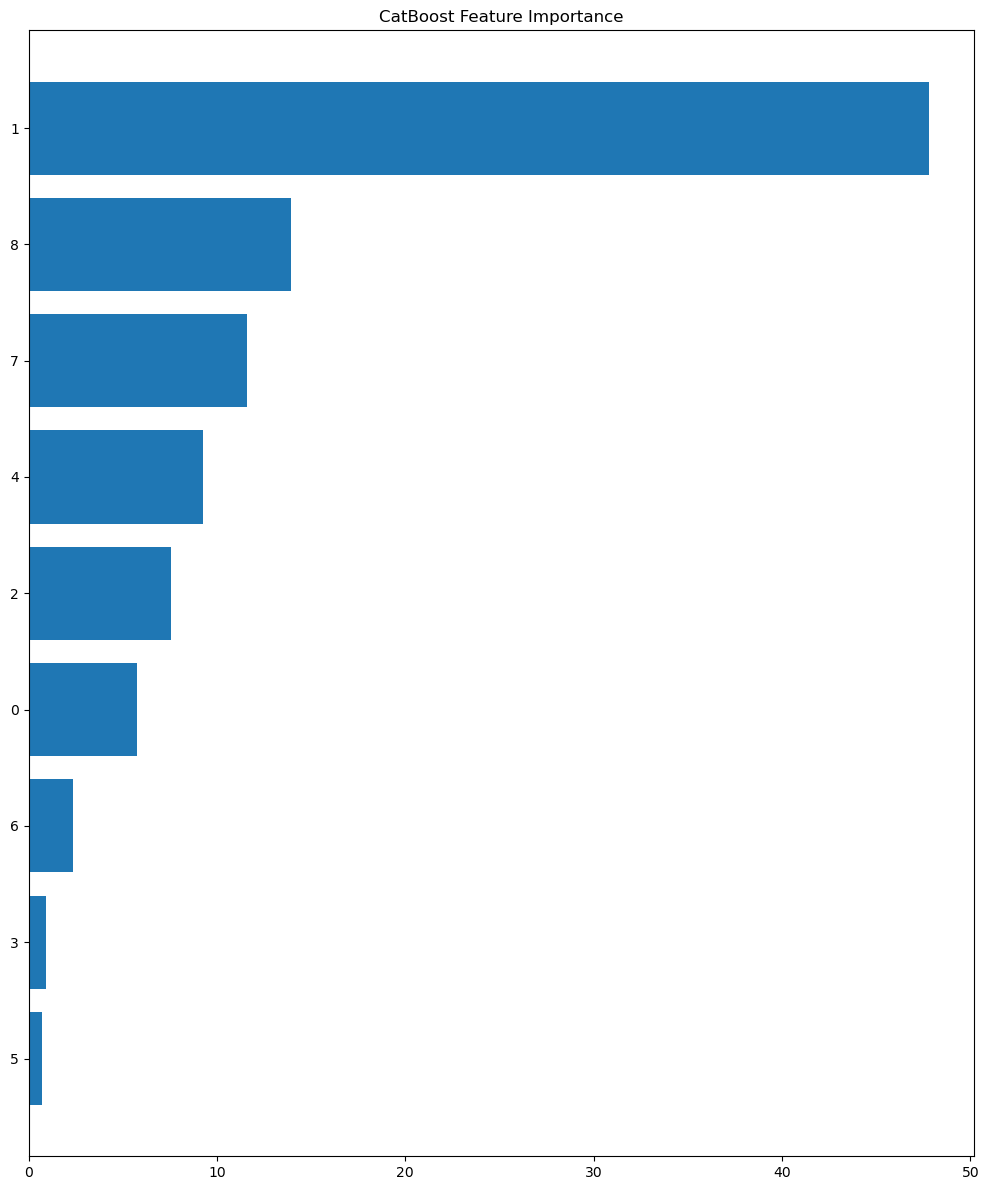

In [43]:
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()
    
fig2 = optuna.visualization.plot_param_importances(study)
fig2.show()
    
# Plot feature importance from the final model
feature_importance = final_model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(range(X.shape[1]))[sorted_idx])
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

It takes 2 minutes to tune CatBoost, which is higher than LightGBM and lesser than XGBoost. CatBoost falls in between LightGBM and XGBoost in terms of speed. However, it is likely to be more accurate than XGBoost and LighGBM, and likely to require lesser tuning as compared to XGBoost.

Check the [documentation](https://catboost.ai/en/docs/references/training-parameters/common) for hyperparameter tuning

###  When to Use **CatBoost** Over **XGBoost**

- When your dataset contains **many categorical features**  
- **CatBoost** tends to perform well **out of the box** with minimal hyperparameter tuning, making it more user-friendly for quick experimentation or deployment  
- CatBoost’s **GPU implementation** is optimized for handling categorical data efficiently, and can **outperform XGBoost** on datasets dominated by categorical variables  
  > While both libraries support GPU acceleration, CatBoost's architecture is particularly well-suited for categorical-heavy tasks


##  Handling Imbalanced Classification: XGBoost vs. LightGBM vs. CatBoost

Imbalanced classification occurs when one class significantly outnumbers the other (e.g., fraud detection, disease diagnosis). Each boosting library offers tools to address this issue.



###  XGBoost

- **Parameter**: `scale_pos_weight`
  - Formula:  
    $$
    \texttt{scale\_pos\_weight} = \frac{\text{Number of negative samples}}{\text{Number of positive samples}}
    $$
  - Increases the gradient of the positive class during training.
- **Additional Strategies**:
  - Use custom `eval_metric` (e.g., `"auc"`, `"aucpr"`, or `"logloss"`)
  - Apply early stopping on validation AUC



###  LightGBM

- **Parameter**: `scale_pos_weight` (same as in XGBoost)
- **Alternative**: `is_unbalance = TRUE`
  - Automatically adjusts class weights based on distribution
- **Other Tips**:
  - Use `metric = "auc"` or `"binary_logloss"` for better guidance during training
  - Resampling techniques also compatible



###  CatBoost

- **Parameter**: `class_weights`
  - Accepts a numeric vector (e.g., `class_weights = c(1, 5)` for [negative, positive])
  - Directly modifies the loss function to emphasize minority class
- **Advantages**:
  - More flexible than `scale_pos_weight`
  - Works well with default settings
- **Other Tips**:
  - Use `loss_function = "Logloss"` and `eval_metric = "AUC"` for binary classification



###  Summary

| Library   | Imbalance Handling Parameter          | Default Support        | Recommended Metric         |
|-----------|----------------------------------------|-------------------------|-----------------------------|
| XGBoost   | `scale_pos_weight`                    | No                      | `auc`, `aucpr`              |
| LightGBM  | `scale_pos_weight`, `is_unbalance`    | Yes (with flag)         | `auc`, `binary_logloss`     |
| CatBoost  | `class_weights`                       | Yes                     | `Logloss`, `AUC`            |

### Common Strategies Across All Libraries

* **Evaluation Metrics:** Use metrics like **F1-score**, **AUC-PR** (Area Under the Precision-Recall Curve), or **Matthews Correlation Coefficient (MCC)** instead of accuracy.
* **Threshold Tuning:** Adjust the decision threshold to prioritize precision or recall.
* **Stratified Sampling:** Ensure balanced splits during train-test splits or cross-validation.



##  Summary: XGBoost vs. LightGBM vs. CatBoost

Gradient boosting is a powerful ensemble technique, and XGBoost, LightGBM, and CatBoost are three of its most widely used implementations. Each has unique strengths and is well-suited to different use cases.

###  XGBoost

- **Strengths**: Robust, well-documented, strong performance on structured/tabular data  
- **Split Finding**: Level-wise tree growth  
- **Regularization**: Explicit L1 and L2 regularization  
- **Flexibility**: Highly customizable with many hyperparameters  
- **Best for**: General-purpose tabular data, especially when you have time to tune parameters

###  LightGBM

- **Strengths**: Fast training, low memory usage, excellent scalability  
- **Split Finding**: Leaf-wise tree growth with depth control  
- **Binning**: Uses histogram-based algorithm with `max_bin` to speed up training  
- **Best for**: Large-scale datasets, high-dimensional features, and when training speed matters

###  CatBoost

- **Strengths**: Handles categorical features natively, works well with minimal tuning  
- **Boosting Innovation**: Uses *ordered boosting* to prevent prediction shift  
- **Categorical Encoding**: No need for manual preprocessing — uses target-based encoding internally  
- **Best for**: Datasets with many categorical variables or limited time for tuning



###  Final Thoughts
All three libraries are powerful and battle-tested. Here's a rough guideline:

- **Use XGBoost** if you want control, flexibility, and a well-documented standard
- **Use LightGBM** when training speed and large data scalability are your top priorities
- **Use CatBoost** when working with many categorical features or seeking strong baseline results with minimal tuning


## References

* [LightGBM Paper (Original NIPS 2017)](https://papers.nips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
* [LightGBM Official Website](https://lightgbm.readthedocs.io/)
* [CatBoost Paper (arXiv)](https://arxiv.org/abs/1810.11363)
* [CatBoost Official Website](https://catboost.ai/)
